In [1]:
import math
import torch
from utils import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import joblib

In [2]:
df = fetch_data()
df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


In [3]:
df.shape

(1944210, 92)

### __Random Forest Regressor__

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(df)

In [13]:
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

In [14]:
# trained on 1/100th of the data
pipeline = Pipeline([
    ('model', RandomForestRegressor())
], verbose=1)

pipeline.fit(X_train_small, y_train_small["responder_6"]);

[Pipeline] ............. (step 1 of 1) Processing model, total= 2.4min


In [15]:
joblib.dump(pipeline, "models/pipeline.pkl")

['models/pipeline.pkl']

In [16]:
# run this cell to load model from file
pipeline = joblib.load("models/pipeline.pkl")

In [ ]:
y_pred = pipeline.predict(X_test)

weights = torch.tensor(y_test['weight'].values)
y_true = torch.tensor(y_test['responder_6'].values)
y_pred = torch.tensor(y_pred)
numerator = torch.sum(weights * (y_true - y_pred) ** 2)
denominator = torch.sum(weights * y_true ** 2)
r2 = (numerator / denominator)
print(f'R^2 Loss: {r2.item()}')

R^2 Loss: 0.9992724208142942


### __MLP (Multi Layer Perceptron)__
- `Context`: `5` __time steps__

- `Input`: `79` __features__ $\times$ `5` __time steps__ = `395` __features__
- `Output`: __Responder 6__
- `Model`: `3` __hidden layers__ with `256`, `128`, `64` __neurons__
- `Activation`: __TanH__
- `Loss`: __Weighted Zero-Mean R-squared Score ($R^2$)__

$$
  R^2 = 1 - \frac{\sum w_i (y_i - \hat{y}_i)^2}{\sum w_i y_i^2}
$$



In [4]:
context = 5
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(df, context=context)
x = torch.tensor(np.concatenate([X_train.drop(columns=['date_id', 'time_id', 'symbol_id']).values, y_train["weight"].values.reshape(-1, 1)], axis=1), dtype=torch.float32)
x.shape

torch.Size([1749789, 396])

torch.Size([1749789, 396])

In [20]:
layers = [
    Linear(79 * context + 1, 256), BatchNorm1d(256), Tanh(),
    Linear(             256, 512), BatchNorm1d(512), Tanh(),
    Linear(             512, 512), BatchNorm1d(512), Tanh(),
    Linear(             512, 512), BatchNorm1d(512), Tanh(),
    Linear(             512, 512), BatchNorm1d(512), Tanh(),
    Linear(             512, 512), BatchNorm1d(512), Tanh(),
    Linear(             512, 256), BatchNorm1d(256), Tanh(),
    Linear(             256,   1)
]

with torch.no_grad():
    layers[0].weight *= 0.02
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [param for layer in layers for param in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

1421569


In [21]:
lossi = []
lri = []
lrs = [1e-3, 1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5, 1e-6, 1e-6, 1e-6]

In [22]:
max_steps = len(lrs) * 10000
batch_size = 64

for i in range(max_steps):
    ix = torch.randint(0, x.shape[0], (batch_size,))
    Xb, yb, yw = x[ix], torch.tensor(y_train['responder_6'].values)[ix], torch.tensor(y_train['weight'].values)[ix]

    for layer in layers:
        Xb = layer(Xb)
    
    Xb = Xb.squeeze()
    loss = (torch.sum(yw * (yb - Xb) ** 2) / torch.sum(yw * yb ** 2))

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lrs[i // 10000]
    for p in parameters:
        p.data -= lr * p.grad

    lossi.append(loss.item())
    lri.append(lr)
    print(f'Step {len(lri):6d} of {max_steps} - R^2 Loss: {loss.item()}', end="\r")

In [25]:
X_loss_calc = X_test
y_loss_calc = y_test

val_input = torch.tensor(np.concatenate([X_loss_calc.drop(columns=['date_id', 'time_id', 'symbol_id']).values, y_loss_calc["weight"].values.reshape(-1, 1)], axis=1), dtype=torch.float32)

for layer in layers:
    val_input = layer(val_input)


print(f"Test Loss: {r2_loss(y_loss_calc, val_input):.8f}")

Test Loss: 0.01912236


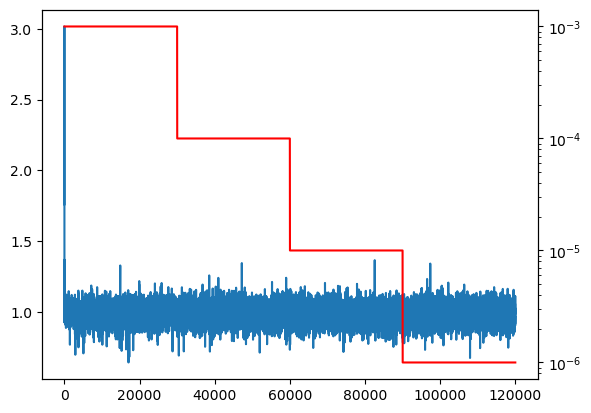

In [16]:
plt.plot(lossi)
alt = plt.twinx()
alt.plot(lri, color='red')
alt.set_yscale('log')